In [1]:
#packages
import numpy as np
import scipy.linalg as la
import networkx as nx 
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pickle


mpl.rcParams['font.family'] = 'serif' #'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

### Functions

In [2]:
def H_CG(N, gamma, w, kappa):
    """
    Generate the Hamiltonian for search on the Complete Graph with a sink at target site.
    
    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: The resulting Hamiltonian in matrix form.
    """
    ket_s = np.ones((N, 1)) / np.sqrt(N) # Initial state (uniform superposition)
    H = -gamma * N * ket_s @ ket_s.T.conj() # Hamiltonian matrix of complete graph
    H = H.astype(complex)
    H[w, w] -= (1 + 1j * kappa)  # Target site
    return H.astype(complex)


def lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambda_plus (float): Eigenenergy of the form a + b
        lambda_minus (float): Eigenenergy of the form a - b
    """
    

    lambda_plus  = -(gamma*N + 1 + 1.0j*kappa)/2  + np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))
    lambda_minus = -(gamma*N + 1 + 1.0j*kappa)/2  - np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))

    return lambda_plus,lambda_minus

def imag_lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the imaginary part of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        imag_lambda_plus (float): Imaginary part of eigenvalue lambda_plus
        imag_lambda_minus (float): Imaginary part of eigenvalue lambda_minus
    """
    
   # a  = ((gamma*N + 1)**2 - kappa**2)/4 - (gamma*N - gamma)
    a = 1/4 + gamma - N*gamma/2 + N*N*gamma*gamma/4 - kappa*kappa/4
    b  = kappa/2 + gamma*kappa - N*gamma*kappa/2
    mod_z = (1/4)*np.sqrt(4*(kappa*kappa)*(-1 + (N-2)*gamma)**2 + (-1 +2*(N - 2)*gamma - N*N*gamma*gamma + kappa*kappa)**2)
    #mod_z = np.sqrt(a**2 + b**2)

    imag_lambda_plus = - kappa/2 + np.sign(b)*np.sqrt((mod_z - a)/2)
    imag_lambda_minus = - kappa/2 - np.sign(b)*np.sqrt((mod_z - a)/2)

    return imag_lambda_plus, imag_lambda_minus

def lambdaR(N,gamma,kappa):

    """
    Compute the analytical expresion of the right eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaR_plus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaR_minus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """   

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- lambda_plus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaR_plus = np.array([a_plus,b_plus])

    a_minus = (- lambda_minus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaR_minus = np.array([a_minus,b_minus])

    return lambdaR_plus, lambdaR_minus


def lambdaL(N,gamma,kappa):

    """
    Compute the analytical expresion of the left eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaL_plus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaL_minus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """  

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- np.conj(lambda_plus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaL_plus = np.array([a_plus,b_plus])

    a_minus = (- np.conj(lambda_minus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaL_minus = np.array([a_minus,b_minus])

    return lambdaL_plus, lambdaL_minus


def overlap(N,gamma,kappa):

    """
    Compute the analytical expresion of the overlaps with initial uniform superposition state. The overlaps corresponds to each term
    in the analytical expression of survival probability (see text for more details). 

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        overlap_plus (float): Overlap correspond to the decay rate governed by Im[lambda_plus].
        overlap_minus (float): Overlap correspond to the decay rate governed by Im[lambda_minus].
        overlap_pm (complex): Overlap correspond to the term having cross terms from both eigenvalues.
    """  

    lambdaR_plus, lambdaR_minus = lambdaR(N,gamma,kappa)
    lambdaL_plus, lambdaL_minus = lambdaL(N,gamma,kappa)

    #initial state
    ket_s = np.array([1.0/np.sqrt(N) ,np.sqrt((N-1)/N)])

    overlap_plus =(1/np.abs(np.vdot(lambdaL_plus,lambdaR_plus))**2)*np.vdot(lambdaR_plus,lambdaR_plus)*np.abs(np.vdot(ket_s, lambdaL_plus))**2

    overlap_minus =(1/np.abs(np.vdot(lambdaL_minus,lambdaR_minus))**2)*np.vdot(lambdaR_minus,lambdaR_minus)*np.abs(np.vdot(ket_s, lambdaL_minus))**2

    #overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)
    #overlap_mp = (1/(np.vdot(lambdaR_minus,lambdaL_minus)*np.vdot(lambdaL_plus,lambdaR_plus)))*np.vdot(ket_s,lambdaL_minus)*np.vdot(lambdaL_plus,ket_s)*np.vdot(lambdaR_minus, lambdaR_plus)
    overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)

    return overlap_plus, overlap_minus,overlap_pm
    

def surv_prob(Tcutoff, dt, r, N, gamma, w, kappa):
    """
    Compute the survival probability as a function of time numerically in a N-dimensional basis. Here reset is done using
    deterministic protocol to the initial state.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        r (int): reset value (such that the time after which we reset is t_reset = r*dt).
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt
    H = H_CG(N, gamma, w, kappa) # Get search Hamiltonian
    psi_0 = np.ones((N, 1)) / np.sqrt(N)  # Initial state (uniform superposition)
    psi_r = psi_0.copy()  # Reset state
    
    s_prob = np.zeros(m) # Initialize array
    s_prob[0] = 1.0  # Initial survival probability
    
    ut = la.expm(-1j * H * dt)  # Time evolution operator

    for j in range(1, m): 
        psit = ut @ psi_0
        s_prob[j] = np.vdot(psit, psit).real  # Survival probability

        if r == 0: #No reset condition
            psi_0 = psit
        else:
            if j%r != 0:  #normal condition    
                psi_0 = psit  
            else: # reset conditions
                psi_0 = np.sqrt(s_prob[j])*psi_r

    return s_prob


def surv_prob_theory_total(Tcutoff, dt,r, N, gamma, w, kappa):

    """
    Compute the survival probability as a function of time analytically in two-dimensional basis without any reset.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        r (int): reset value (such that the time after which we reset is t_reset = r*dt).
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
 
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt

    #eigenvalues
    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    #overlaps 
    overlap_plus, overlap_minus,overlap_pm = overlap(N,gamma,kappa)
   
    s_prob = np.zeros(m) # Initialize array

    for j in range(m): 
        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*j*dt)*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*j*dt)*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*j*dt)*overlap_pm)

        s_prob[j] = first_term + second_term +third_term


    return s_prob

       
def find_transition_point(arr, dt): # EMMA
    """
    Find the first time index where the survival probability (SP) drops below 0.5.
    
    Args:
        arr (numpy array): Array of survival probability values.
        dt (float): Discretization of time into time steps of duration dt.
        
    Returns:
        float: Time at which SP drops below the value of 1/2.
    """
    idx = np.where(arr <= 0.5)[0]
    return idx[0] * dt if len(idx) > 0 else 0  # Return first occurrence or 0

def find_transition_point2(arr, dt): # SAYAN
    
    """
    Find the first time index where the survival probability (SP) drops below 0.5 using bisection method.
    
    Args:
        arr (numpy array): Array of survival probability values.
        dt (float): Discretization of time into time steps of duration dt.
        
    Returns:
        float: Time at which SP drops below the value of 1/2.
    """

    
    left, right = 0, len(arr) - 1
    
    while left < right:
        mid = (left + right) // 2
        if arr[mid] > 0.5:
            left = mid + 1  # Search in the right half
        else:
            right = mid  # Search in the left half
            
    return left * dt if arr[left] <= 0.5 else 0  # Return index or 0 if no transition

In [141]:
# Parameters
Tcutoff = 400
dt = 0.05
r_vals = [0]
kappa_vals = np.linspace(0, 0.4, 20)
N = 100  # System size
w = 10  # Target site
gamma_vals = np.linspace(0.8/N, 1.2/N, 20)

# Storage Arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
            s_prob_arr[gg, kk, rr] = s_prob
            #print(find_transition_point2(s_prob, dt),gamma,kappa,r)
            T_decay0p5[gg, kk, rr] = find_transition_point(s_prob, dt)
            
#filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

100%|███████████████████████████████████████████| 20/20 [04:28<00:00, 13.42s/it]


In [150]:
# Parameters
Tcutoff = 400
dt = 0.05
r_vals = [0]
kappa_vals = np.linspace(0, 0.4, 20)
N = 500  # System size
w = 10  # Target site
gamma_vals = np.linspace(0.8/N, 1.2/N, 20)

# Storage Arrays
T_decay0p5_theory = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr_theory = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob_theory = surv_prob_theory_total(Tcutoff, dt, r, N, gamma, w, kappa)
            s_prob_arr_theory[gg, kk, rr] = s_prob_theory
            #print(find_transition_point2(s_prob, dt),gamma,kappa,r)
            T_decay0p5_theory[gg, kk, rr] = find_transition_point(s_prob_theory, dt)

/tmp/ipykernel_4512/3169854336.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


In [145]:
# Extract optimal reset rate and minimum search times --- TO BE VERIFIED LATER!!!
T_min = np.zeros((len(gamma_vals), len(kappa_vals)))
#r_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
T_decay0p5 = np.where(T_decay0p5==0, np.inf, T_decay0p5)

for gg in tqdm(range(len(gamma_vals))):
    for kk in range(len(kappa_vals)):
        T_decay_temp = T_decay0p5[gg, kk]
        if len(T_decay_temp) > 0:
            T_min[gg, kk] = np.min(T_decay_temp)
            #r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
        else:
            T_min[gg, kk] = np.nan  # Mark undefined cases
            #r_optimal[gg, kk] = np.nan


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 9749.66it/s]


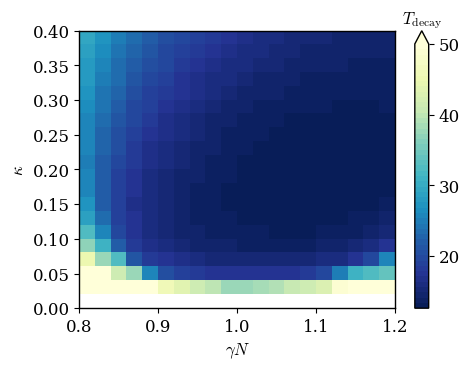

In [146]:
# Visualization - Minimum search time heatmap & Optimal reset rate heatmap
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
im1 = ax1.imshow(T_min.T, origin='lower', aspect='auto',
                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N,kappa_vals[0], kappa_vals[-1]],
                 cmap=plt.get_cmap('YlGnBu_r',50), vmax=50)
ax1.set_ylabel(r"$\kappa$")
ax1.set_xlabel(r"$\gamma N$")
#ax1.set_title("Minimum search time $T_{\min}$")
cbar = fig.colorbar(im1, ax=ax1, extend = "max")
cbar.ax.set_title(r'$T_{\rm decay}$', size = 12,pad = 15)

#plot_settings(ax1,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

#ax2 = axes[1]
#im2 = ax2.imshow(r_optimal.T, origin='lower', aspect='auto',
#                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N, kappa_vals[0], kappa_vals[-1]],
#                 cmap=plt.get_cmap('YlGnBu_r',300), vmax=400)
#ax2.set_ylabel(r"$\kappa$")
#ax2.set_xlabel(r"$\gamma N$")
#ax2.set_title("Optimal reset rate $r_{\mathrm{opt}}$")
#fig.colorbar(im2, ax=ax2, extend = "max")
#plot_settings(ax2,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

plt.tight_layout()

#plt.savefig('../Figures/Final/decay_time_sprob.pdf', bbox_inches ='tight', transparent = True, dpi = 800)
plt.show()

In [151]:
# Extract optimal reset rate and minimum search times --- TO BE VERIFIED LATER!!!
T_min_theory = np.zeros((len(gamma_vals), len(kappa_vals)))
#r_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
T_decay0p5_theory = np.where(T_decay0p5_theory==0, np.inf, T_decay0p5_theory)

for gg in tqdm(range(len(gamma_vals))):
    for kk in range(len(kappa_vals)):
        T_decay_temp = T_decay0p5_theory[gg, kk]
        if len(T_decay_temp) > 0:
            T_min_theory[gg, kk] = np.min(T_decay_temp)
            #r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
        else:
            T_min_theory[gg, kk] = np.nan  # Mark undefined cases
            #r_optimal[gg, kk] = np.nan


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 5429.87it/s]


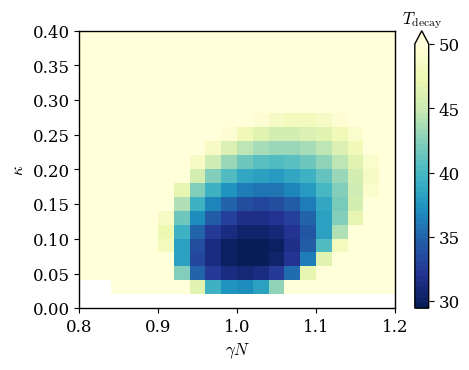

In [152]:
# Visualization - Minimum search time heatmap & Optimal reset rate heatmap
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
im1 = ax1.imshow(T_min_theory.T, origin='lower', aspect='auto',
                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N,kappa_vals[0], kappa_vals[-1]],
                 cmap=plt.get_cmap('YlGnBu_r',50), vmax=50)
ax1.set_ylabel(r"$\kappa$")
ax1.set_xlabel(r"$\gamma N$")
#ax1.set_title("Minimum search time $T_{\min}$")
cbar = fig.colorbar(im1, ax=ax1, extend = "max")
cbar.ax.set_title(r'$T_{\rm decay}$', size = 12,pad = 15)

#plot_settings(ax1,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

#ax2 = axes[1]
#im2 = ax2.imshow(r_optimal.T, origin='lower', aspect='auto',
#                 extent=[gamma_vals[0]*N, gamma_vals[-1]*N, kappa_vals[0], kappa_vals[-1]],
#                 cmap=plt.get_cmap('YlGnBu_r',300), vmax=400)
#ax2.set_ylabel(r"$\kappa$")
#ax2.set_xlabel(r"$\gamma N$")
#ax2.set_title("Optimal reset rate $r_{\mathrm{opt}}$")
#fig.colorbar(im2, ax=ax2, extend = "max")
#plot_settings(ax2,[[0.8,1.2],[0,0.4]],[0.1,0.02,0.1,0.02],True)

plt.tight_layout()

#plt.savefig('../Figures/Final/decay_time_sprob.pdf', bbox_inches ='tight', transparent = True, dpi = 800)
plt.show()

In [149]:
(T_min_theory==T_min).all()

np.True_

### Adaptive Grid size 

In [76]:
# Parameters
r_vals = [0]
w = 10
kappa_vals = np.linspace(0, 0.4, 100)
NList =  np.floor(np.logspace(2,5,50))# System size


for N in tqdm(NList):

    Tcutoff = 2*np.sqrt(N) # cutoff time increasing with square root of N
    dt = 0.05


    gamma_vals = np.linspace(0.9/N, 1.1/N, 100)
    
    # Storage Arrays
    T_decay0p5_theory = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
    s_prob_arr_theory = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))
    
    # Compute Survival Probabilities and Transition Points
    for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
        for kk, kappa in enumerate(kappa_vals):
            for rr, r in enumerate(r_vals):
                s_prob_theory = surv_prob_theory_total(Tcutoff, dt, r, N, gamma, w, kappa)
                s_prob_arr_theory[gg, kk, rr] = s_prob_theory
                #print(find_transition_point2(s_prob, dt),gamma,kappa,r)
                T_decay0p5_theory[gg, kk, rr] = find_transition_point(s_prob_theory, dt)
    
    filename = f"Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_NO_SPROB_theory.pkl"
    dict_to_save = [gamma_vals, kappa_vals, r_vals, T_decay0p5_theory]
    with open(filename, 'wb') as f:
        pickle.dump(dict_to_save, f)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_557310/3169854336.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 50/50 [1:45:21<00:00, 126.43s/it]


### visualizations

In [3]:
# Parameters
NList =  np.floor(np.logspace(2,5,50))# System size


runtimes = np.zeros(len(NList))
gammaN_opts = np.zeros(len(NList))
kappa_opts = np.zeros(len(NList))

for j, N in enumerate(NList):

    Tcutoff = 2*np.sqrt(N)
    dt = 0.05

    filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_NO_SPROB_theory.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    gamma_vals, kappa_vals, r_vals, T_decay0p5_theory = data

    T_min_theory = np.zeros((len(gamma_vals), len(kappa_vals)))
    T_decay0p5_theory = np.where(T_decay0p5_theory==0, np.inf, T_decay0p5_theory)

    for gg in tqdm(range(len(gamma_vals))):
        for kk in range(len(kappa_vals)):
            T_decay_temp = T_decay0p5_theory[gg, kk]
            if len(T_decay_temp) > 0:
                T_min_theory[gg, kk] = np.min(T_decay_temp)
                #r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
            else:
                T_min_theory[gg, kk] = np.nan  # Mark undefined cases
                #r_optimal[gg, kk] = np.nan

    id = np.unravel_index(T_min_theory.argmin(), T_min_theory.shape)
    runtimes[j] = T_min_theory[np.unravel_index(T_min_theory.argmin(), T_min_theory.shape)]
    gammaN_opts[j] = gamma_vals[id[0]]*N
    kappa_opts[j] = kappa_vals[id[1]]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2037.87it/s]


In [4]:
def timeScaling(Nlist):
    return [np.sqrt(N) for N in Nlist]

data = timeScaling(NList)

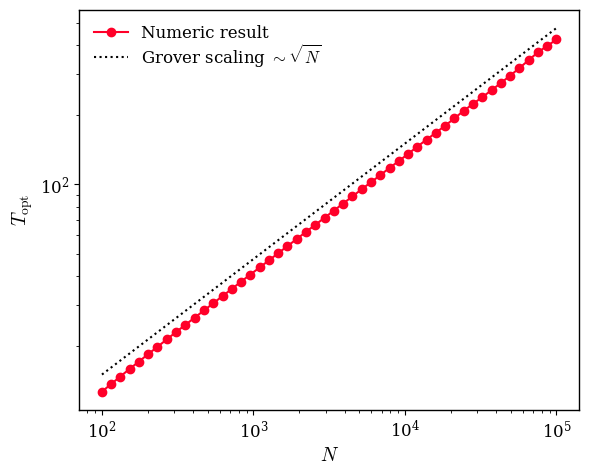

In [5]:
fig = plt.figure(figsize=(5,4)) #Generate figure with a given size
ax = fig.add_axes([0, 0, 1, 1]) #Add axes object to our figure that takes up entire figure

colors = plt.get_cmap('gist_rainbow', 16)
plt.plot(NList, runtimes, color=colors(0), marker='o', linestyle='-', label="Numeric result")
plt.plot(NList, 1.5*np.array(data), color="k", ls=":", label=r"Grover scaling $\sim \sqrt{N}$")
plt.xlabel(r"$N$",size = 14) #x-axis label
plt.ylabel(r"$T_{\mathrm{opt}}$", size = 14) #y-axis label
plt.legend(loc= 0, prop={'size': 12}, labelspacing=0.01, frameon=False)
plt.yscale('log')
plt.xscale('log')
#filename = f"Overlaps_figure_N{N}_dim{d}_alpha{alpha_str}.pdf"

#plt.tight_layout()
#plt.savefig("../Figures/Final/CompleteGraphTopt.pdf", dpi=800, transparent=True, bbox_inches='tight')

#plt.savefig('scaling.pdf',bbox_inches = 'tight')
plt.show()

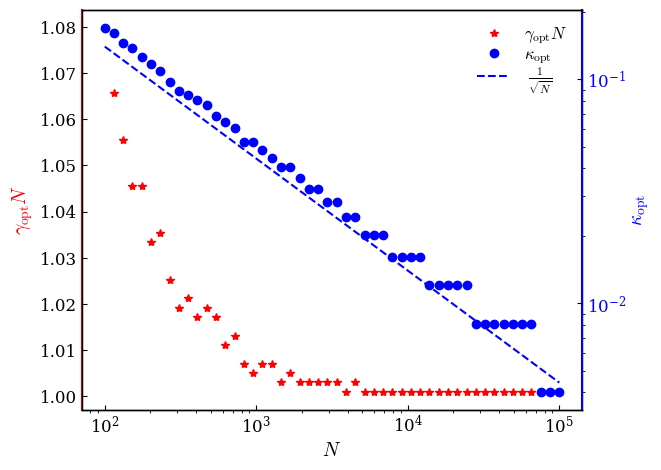

In [6]:
fig = plt.figure(figsize=(5,4))  # Same size as the first plot
ax1 = fig.add_axes([0, 0, 1, 1])  # Primary axis

# Energy curves on the primary y-axis
ax1.plot(NList, gammaN_opts,'*', label=r"$\gamma_{\rm opt} N$", color="red")

# Primary axis settings
ax1.set_xlabel(r"$N$", size =14)
#plt.title(r"Optimal parameter values", color="black")
ax1.set_ylabel(r"$\gamma_{\rm opt} N$", color="red", size = 14)
ax1.tick_params(axis="both", direction="in", labelcolor="black")
ax1.spines["left"].set_color("red")
ax1.spines["left"].set_linewidth(1.5)
ax1.set_xscale('log')

# Add a secondary y-axis for purity
ax2 = ax1.twinx()
ax2.plot(NList, kappa_opts,'o', label=r"$\kappa_{\rm opt}$", color="blue")
ax2.set_ylabel(r"$\kappa_{\rm opt}$", color="blue", size = 14)
ax2.tick_params(axis="y", direction="in", labelcolor="blue")
ax2.spines["right"].set_color("blue")
ax2.spines["right"].set_linewidth(1.5)
ax2.plot(NList,1.4/np.sqrt(NList),'--', label=r"$~\frac{1}{\sqrt{N}}$", color="blue")


ax2.set_xscale('log')
ax2.set_yscale('log')


# Combined legend
lns1, labels1 = ax1.get_legend_handles_labels()
lns2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lns1 + lns2, labels1 + labels2, loc="upper right", prop={'size': 12}, labelspacing=0.01, frameon=False)

#plt.tight_layout()

#plt.savefig("gamma_kappa_opt.pdf", dpi=800, transparent=True, bbox_inches='tight')


plt.show()

In [8]:
overlap_plus = np.zeros(len(NList),dtype = 'complex')
overlap_minus = np.zeros(len(NList),dtype = 'complex')
overlap_pm = np.zeros(len(NList),dtype = 'complex')

lambda_plus = np.zeros(len(NList),dtype = 'complex')
lambda_minus = np.zeros(len(NList),dtype = 'complex')

for i in range(len(NList)):

    lambda_plus[i], lambda_minus[i]= lambda_pm(NList[i], gammaN_opts[i]/NList[i], kappa_opts[i])
    
    overlap_plus[i], overlap_minus[i], overlap_pm[i] =  overlap(NList[i], gammaN_opts[i]/NList[i], kappa_opts[i])

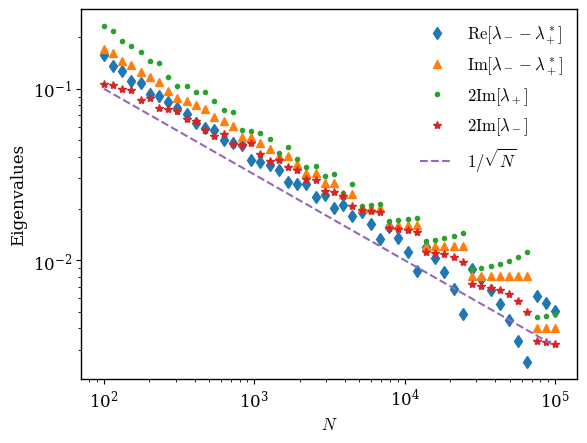

In [9]:

plt.plot(NList, np.abs( np.real(lambda_minus - np.conj(lambda_plus))),'d', label = r'$ \text{Re} [\lambda_- - \lambda_+^*]$')
plt.plot(NList,np.abs( np.imag(lambda_minus - np.conj(lambda_plus))),'^', label = r'$ \text{Im} [\lambda_- - \lambda_+^*]$')
plt.plot(NList, np.abs(2*np.imag(lambda_plus)),'.', label = r'$2 \text{Im} [\lambda_+]$')
plt.plot(NList, np.abs(2*np.imag(lambda_minus)),'*', label = r'$2 \text{Im} [\lambda_-]$')

plt.plot(NList, 1/np.sqrt(NList),'--', label = r'$1/\sqrt{N}$')

plt.legend(frameon = False)
plt.xlabel(r'$N$')
plt.ylabel(r'Eigenvalues')

plt.xscale('log')
plt.yscale('log')
#plt.savefig(r'eigvals.pdf',bbox_inches = 'tight')
plt.show()

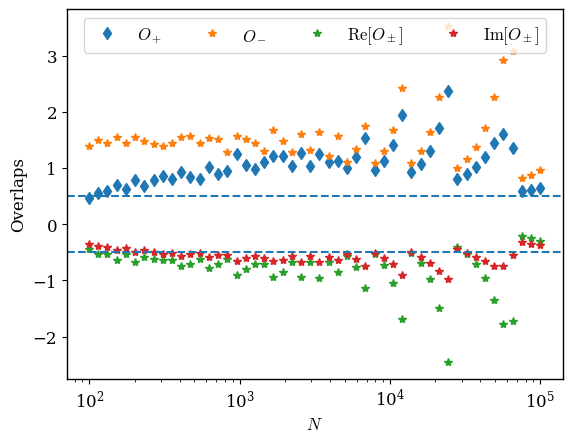

In [10]:
plt.plot(NList, np.real(overlap_plus),'d', label = r'$O_+$')
plt.plot(NList, np.real(overlap_minus),'*', label = r'$O_-$')

plt.plot(NList, np.real(overlap_pm),'*', label = r'$\text{Re}[O_\pm]$')
plt.plot(NList, np.imag(overlap_pm),'*', label = r'$\text{Im}[O_\pm]$')

plt.legend(frameon = True,ncol=4, loc='upper center')
plt.xlabel(r'$N$')
plt.ylabel(r'Overlaps')
plt.xscale('log')

plt.axhline(0.5,linestyle ='--')
plt.axhline(-0.5,linestyle ='--')
#plt.savefig('overlap.pdf', bbox_inches = 'tight')
plt.show()

### Individual trajectories of survival probabilities

/tmp/ipykernel_16050/3089882125.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term


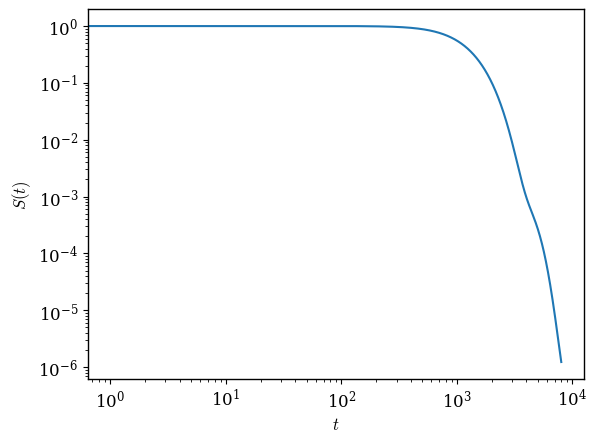

In [22]:
n = 20
sprob_individual = surv_prob_theory_total(400,0.05,0,NList[n], gammaN_opts[n]/NList[n],10,kappa_opts[n])
m = int(400 / 0.05) 


plt.plot(np.arange(m),sprob_individual)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t)$')

plt.yscale('log')
plt.xscale('log')
plt.show()


In [ ]:
def surv_prob_theory_total(Tcutoff, dt,r, N, gamma, w, kappa):

    """
    Compute the survival probability as a function of time analytically in two-dimensional basis without any reset.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        r (int): reset value (such that the time after which we reset is t_reset = r*dt).
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
 
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt

    #eigenvalues
    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    #overlaps 
    overlap_plus, overlap_minus,overlap_pm = overlap(N,gamma,kappa)
   
    s_prob = np.zeros(m) # Initialize array

    for j in range(m): 
        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*j*dt)*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*j*dt)*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*j*dt)*overlap_pm)

        s_prob[j] = first_term + second_term +third_term


    return s_prob